### Using Tree data

In [1]:
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import gaussian_process

dendro = pd.read_feather("data/17766_12.feather")
dendro

,dendroNr,DOY,species,growth
0,HA_001_2012,0,Beech,0.000000
1,HA_001_2012,1,Beech,0.154100
2,HA_001_2012,2,Beech,1.460225
3,HA_001_2012,3,Beech,4.169183
4,HA_001_2012,4,Beech,3.907183
...,...,...,...,...
30805,SH_076_2013,178,Beech,3909.054208
30806,SH_076_2013,179,Beech,3908.649604
30807,SH_076_2013,180,Beech,3908.473708
30808,SH_076_2013,181,Beech,3908.421000


# Fit models

In [19]:
%%capture
# Import my GP
%run ./GP.ipynb

ValueError: unrecognized csr_matrix constructor usage

ValueError: unrecognized csr_matrix constructor usage

In [160]:

from liesel_sparse import band
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import jax.numpy as jnp
import jax

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

tree_models = [
    GaussianProcessRegressor(
       0.2 * RBF(30), n_restarts_optimizer=10, alpha=1e-1
    )
    # 0
    for _ in range(3)
]

X = np.linspace(0, max(dendro.DOY), 1000).reshape(-1, 1)

for i, tree_model in enumerate(tree_models):
    # Filter to prevent overfitting to data mean
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i])]
    filt = filt.groupby("DOY", as_index = False).mean(numeric_only=True) # Fit on means?
    filt = filt.sample(int(0.05 * len(filt)), random_state=1)

    data_x = jnp.array(filt.DOY.array.reshape(-1, 1))
    data_y = jnp.array(filt.growth)

    match i:
        case 0: mean_prediction = 2100 * weibull_F(data_x.squeeze(), 1/100, 3)
        case 1: mean_prediction = 1650 * weibull_F(data_x.squeeze(), 1/95, 3.5)
        case _: mean_prediction = 1450 * weibull_F(data_x.squeeze(), 1/60, 2.5)

    data_y -= mean_prediction

    #MINE
    # def kernel(s1, l1, x, y):
    #     return RBFKernel(s1, l1, x, y)
    # tree_model = GPR(data_x, data_y, kernel, jnp.array([0.2**2, 30.]), eps=1e-2)
    # tree_models[i] = tree_model
    # #tree_model.fit()

    tree_model.fit(data_x, data_y)
    print(-tree_model.log_marginal_likelihood_value_, 'at', tree_model.kernel_)

    # if i == 0:
    #     tree_model.predict(X)
    #     fig, ax = plt.subplots(figsize=(15, 6), ncols=2)
    #
    #     L = jax.jit(band.to_ltri_full)(tree_model.Lb_)
    #     K = L @ L.T
    #
    #     #K = np.array(K)
    #     #K[np.isclose(K, 0, atol=1e-2)] = 0
    #     #K = jnp.where(K < 1e-2, 0, K)
    #
    #     cax = ax[0].matshow(K, norm=matplotlib.colors.LogNorm())
    #     fig.colorbar(cax)
    #     ax[1].hist(K.flatten(), bins=100, range=(0, 0.04))

37.14475098990491 at 24.5**2 * RBF(length_scale=12.6)
46.844974047412215 at 51.3**2 * RBF(length_scale=3.7)
47.0039710286986 at 90.4**2 * RBF(length_scale=16.2)


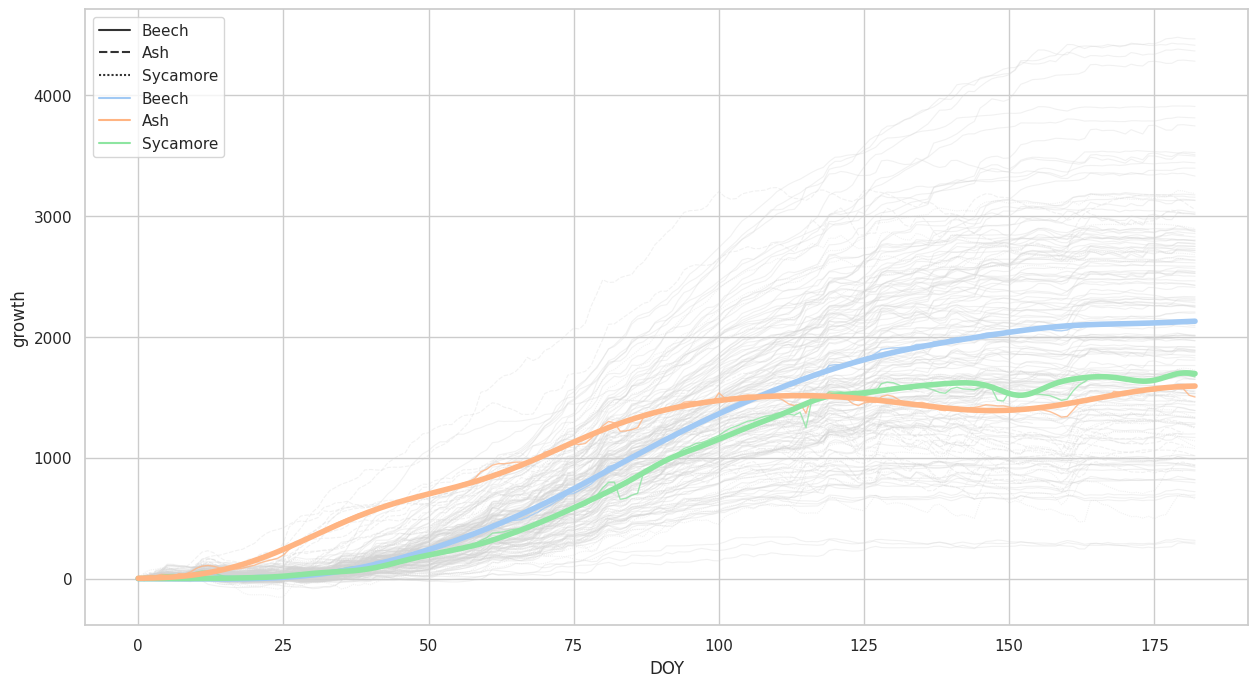

In [161]:
fig = plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid", palette="pastel")

# All lines
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    style="species",
    units="dendroNr",
    lw=0.8,
    estimator=None,
    c="lightgray",
    alpha=0.3,
)

# Plot means
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    hue="species",
    #estimator=None, errorbar=('ci', 99),
    errorbar=None,
    lw=1,
    zorder=2,
    alpha=0.8,
)

# Plot GP
for i, tree_model in enumerate(tree_models):
    match i:
        case 0: mean_prediction = 2100 * weibull_F(X.ravel(), 1/100, 3)
        case 1: mean_prediction = 1650 * weibull_F(X.ravel(), 1/95, 3.5)
        case _: mean_prediction = 1450 * weibull_F(X.ravel(), 1/60, 2.5)

    mean_prediction = tree_model.predict(X) + mean_prediction

    sns.lineplot(
        x=X.ravel(),
        y=mean_prediction.ravel(),
        lw=4,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )
    continue
    std_prediction = 1000 #?
    plt.fill_between(
        X.ravel(),
        (mean_prediction - 1.96 * std_prediction).ravel(),
        (mean_prediction + 1.96 * std_prediction).ravel(),
        alpha=.2,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )

plt.show()

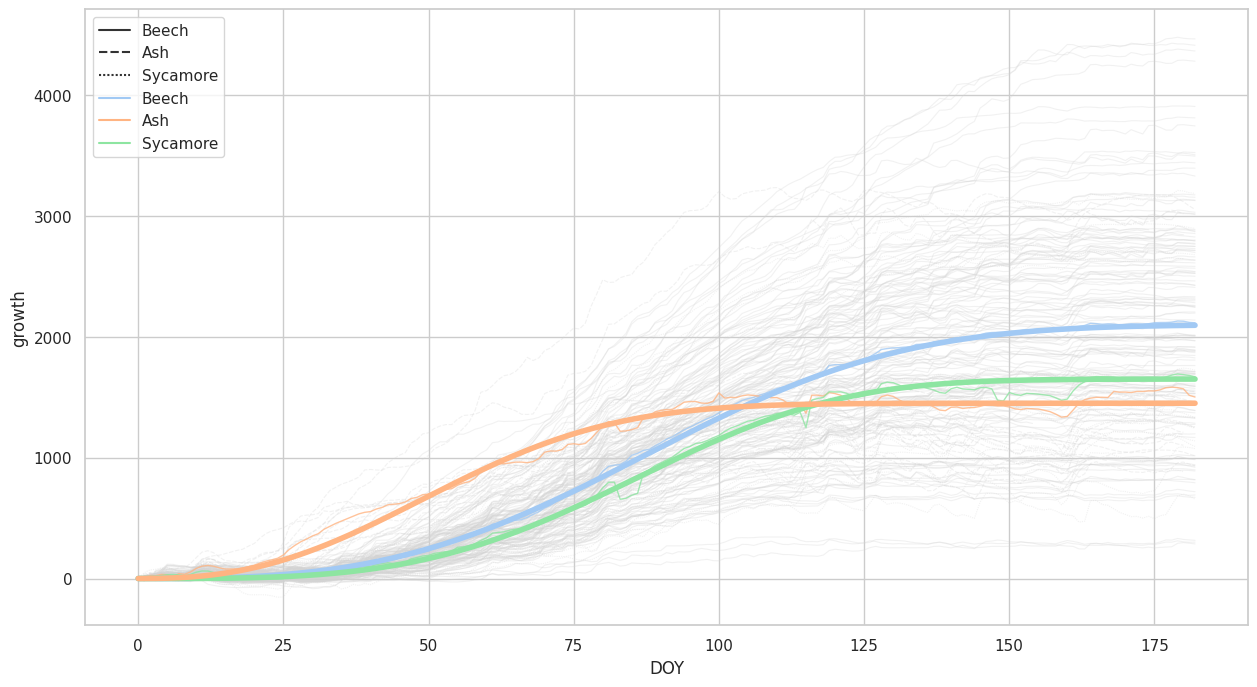

In [46]:
fig = plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid", palette="pastel")

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

# All lines
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    style="species",
    units="dendroNr",
    lw=0.8,
    estimator=None,
    c="lightgray",
    alpha=0.3,
)

# Plot means
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    hue="species",
    #estimator=None, errorbar=('ci', 99),
    errorbar=None,
    lw=1,
    zorder=2,
    alpha=0.8,
)

# Plot Weibull
for i, tree_model in enumerate(tree_models):
    match i:
        case 0: mean_prediction = 2100 * weibull_F(X.ravel(), 1/100, 3)
        case 1: mean_prediction = 1650 * weibull_F(X.ravel(), 1/95, 3.5)
        case 2: mean_prediction = 1450 * weibull_F(X.ravel(), 1/60, 2.5)

    sns.lineplot(
        x=X.ravel(),
        y=mean_prediction.ravel(),
        lw=4,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )

plt.show()